<a href="https://colab.research.google.com/github/aadarsh0709/gnnmodelpfas/blob/main/simplemodelgnnidsmilesgraphconversionv0222.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch-geometric rdkit pubchempy dataframe_image

import pandas as pd
import torch
from torch_geometric.data import Data, Dataset
from sklearn.model_selection import train_test_split
from rdkit import Chem
import requests
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pubchempy
import rdkit
import time
import torch.nn.functional as F
import warnings
from pandas.plotting import table
from rdkit.Chem import Draw
from sklearn.metrics import r2_score
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import to_networkx
from torch.nn import Linear
from tqdm import tqdm
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelEncoder
from torch_geometric.loader import DataLoader
from rdkit.Chem import rdMolDescriptors
import typing

warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 MB 43.4 MB/s eta 0:00:00
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13819 sha256=2dfd38ca12abebf52aaf6e44d8ce77d3fd1a12394397e2f5ee453b658fbba191
  Stored in directory: /root/.cache/pip/wheels/8b/e3/6c/3385b2db08b0985a87f5b117f98d0cb61a3ae3ca3bcbbd8307
Successfully built pubchempy


In [ ]:
#Read the CSV file
df = pd.read_csv('https://raw.githubusercontent.com/aadarsh0709/gnnmodelpfas/refs/heads/main/S3_Dawsonetal_PFAS_HL_101122.csv')

#df = pd.read_csv('https://raw.githubusercontent.com/aadarsh0709/gnnmodelpfas/refs/heads/main/PFAS_half_life_data.csv')

#smilesdf=pd.read_csv('https://raw.githubusercontent.com/aadarsh0709/gnnmodelpfas/refs/heads/main/smiles.csv')


# Preprocessing

In [ ]:
import pubchempy as pcp
from rdkit.Chem import Descriptors

def get_smiles_by_cas(cas_number):
    """
    Retrieves the SMILES string for a given CAS number using PubChem.

    Parameters:
        cas_number (str): The CAS number of the compound.

    Returns:
        str: The corresponding SMILES string if found, otherwise an error message.
    """
    try:
        # Search for compounds using the CAS number
        compounds = pcp.get_compounds(cas_number, 'name')
        if not compounds:
            return "Not Found"

        # Retrieve the SMILES string of the first matched compound
        compound = compounds[0]
        smile=compound.isomeric_smiles
        mol = Chem.MolFromSmiles(smile)
        molWeight = Descriptors.ExactMolWt(mol)
        nofrings = mol.GetRingInfo().NumRings()
        psa = rdMolDescriptors.CalcTPSA(mol)

        return [ compound.exact_mass, smile, carbon_chain_length(smile) , count_fluorinated_carbons(mol), molWeight , nofrings,psa]
    except Exception as e:
        # Return the error message in case of an exception
        return f"Error: {e}"

In [ ]:
from sklearn.preprocessing import StandardScaler

# get global feature
def getGlobalFeatures(sex, species, DosingAdj, mass, chainlength, cflength, molwight, nofrings, psa):

  # get all feature data
  global_features = {
      "Sex": sex,
      "Species": species,
      "DosingAdj": DosingAdj,
      "MASS": mass,
      "chainlength": chainlength,
      "cflength": cflength,
      "molWeight": molwight,
      "nofrings": nofrings,
      "psa": psa
  }

#Normalize the global features
  global_features_array = np.array(list(global_features.values()))
  global_features_array = global_features_array.reshape(1, -1)


  scaler = StandardScaler()
  global_features_array = scaler.fit_transform(global_features_array)

  return global_features_array

#Get the atom features (Node)
def atom_features(atom):

    IsCFBond=0
    if atom.GetSymbol() == 'C' and any(neighbor.GetSymbol() == 'F' for neighbor in atom.GetNeighbors()):
        IsCFBond=1

    return [
        atom.GetTotalNumHs(),
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetFormalCharge(),
        atom.GetNumRadicalElectrons(),
        int(atom.GetChiralTag()),
        int(atom.GetIsAromatic()),
        int(atom.IsInRing()),
        IsCFBond,
        atom.GetHybridization()
    ]

#Get the bond features (Edge)
def bond_features(bond):
    return torch.tensor([
        int(bond.GetBondType()),
        int(bond.GetIsConjugated()),
        int(bond.IsInRing()),
        int(bond.GetBondDir())
    ], dtype=torch.float32)

# find chain lenngth
def carbon_chain_length(smiles):
    carbon_count = 0
    for atom in smiles:
        if atom == 'C':  # Count only carbon atoms
            carbon_count += 1
    return carbon_count

# find count of CF bonds
def count_fluorinated_carbons(molecule):
    fluorinated_carbons = 0
    for atom in molecule.GetAtoms():
        if atom.GetSymbol() == 'C' and any(neighbor.GetSymbol() == 'F' for neighbor in atom.GetNeighbors()):
            fluorinated_carbons += 1
    return fluorinated_carbons


In [ ]:
#pull list of unique casrns
unique_casrns = list(df["CASRN"].unique())
smiles_dict = {}
mass_dict = {}
chainlenght_dict = {}
cflength_dict = {}
molWeight_dist= {}
norings_dist = {}
psa_dist = {}

count=0
print("# of unique casrns= ",len(unique_casrns))

# of unique casrns=  6603


In [ ]:
import time
# Iterate through unique CASRNs and get SMILES
for casrn in unique_casrns:
    time.sleep(0.125)
    smilesandmass =  get_smiles_by_cas(casrn)
    #print(smilesandmass)
    mass_dict[casrn] =  smilesandmass[0]
    smiles_dict[casrn] = smilesandmass[1]
    chainlenght_dict[casrn] =  smilesandmass[2]
    cflength_dict[casrn] =  smilesandmass[3]
    molWeight_dist[casrn] =  smilesandmass[4]
    norings_dist[casrn] =  smilesandmass[5]
    psa_dist[casrn] =  smilesandmass[6]



In [ ]:
#Add the SMILES column to the DataFrame
df['SMILES'] = df['CASRN'].map(smiles_dict)
df['MASS'] = df['CASRN'].map(mass_dict)
df['ChainLength'] = df['CASRN'].map(chainlenght_dict)
df['cflength'] = df['CASRN'].map(cflength_dict)
df['molWeight'] = df['CASRN'].map(molWeight_dist)
df['nofrings'] = df['CASRN'].map(norings_dist)
df['psa'] = df['CASRN'].map(psa_dist)


#Remove the parts where the CASRN has no SMILES in the DataFrame
df = df[(df['SMILES'].notna()) & (df['SMILES'] != 'Not Found')]

missing_smiles = df[df['SMILES'].isnull()]
print("CASRNs with missing SMILES:")
print(missing_smiles[['CASRN']])

df.drop(df[df['SMILES'] == "o"].index, inplace=True)
df.drop(df[df['SMILES'] == "r"].index, inplace=True)

unique_casrns_count = df['CASRN'].nunique()
print(f"Number of unique CASRNs: {unique_casrns_count}")


CASRNs with missing SMILES:
Empty DataFrame
Columns: [CASRN]
Index: []
Number of unique CASRNs: 6472


In [ ]:
print(df.head())


        CASRN          DTXSID  Name Species     Sex DosingAdj  HalfLife.h  \
0  85571-83-1  DTXSID50897563   NaN  Cattle    Male        IV       52.55   
1  85571-83-1  DTXSID50897563   NaN  Cattle    Male      Oral       52.55   
2  85571-83-1  DTXSID50897563   NaN  Cattle    Male     Other       52.55   
3  85571-83-1  DTXSID50897563   NaN  Cattle  Female        IV       52.55   
4  85571-83-1  DTXSID50897563   NaN  Cattle  Female     Other       52.55   

   kelim.h  Source  NObs  Multimodal  FittedDist                       SMILES  \
0   0.0132     NaN   NaN         NaN         NaN  CC(C(C(C(F)(F)F)(F)F)(F)F)O   
1   0.0132     NaN   NaN         NaN         NaN  CC(C(C(C(F)(F)F)(F)F)(F)F)O   
2   0.0132     NaN   NaN         NaN         NaN  CC(C(C(C(F)(F)F)(F)F)(F)F)O   
3   0.0132     NaN   NaN         NaN         NaN  CC(C(C(C(F)(F)F)(F)F)(F)F)O   
4   0.0132     NaN   NaN         NaN         NaN  CC(C(C(C(F)(F)F)(F)F)(F)F)O   

           MASS ChainLength cflength   molWeight n

In [ ]:
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer

binsize=5

# K-means binning
kmeans_binner = KBinsDiscretizer(n_bins=binsize, encode='ordinal', strategy='kmeans', random_state =0)
df['kmeans_bin'] = kmeans_binner.fit_transform(df[['HalfLife.h']])


# Quantile-based binning
quantile_binner = KBinsDiscretizer(n_bins=binsize, encode='ordinal', strategy='quantile', random_state =0)
df['quantile_bin'] = quantile_binner.fit_transform(df[['HalfLife.h']])

In [ ]:
print(df.head())


        CASRN          DTXSID  Name Species     Sex DosingAdj  HalfLife.h  \
0  85571-83-1  DTXSID50897563   NaN  Cattle    Male        IV       52.55   
1  85571-83-1  DTXSID50897563   NaN  Cattle    Male      Oral       52.55   
2  85571-83-1  DTXSID50897563   NaN  Cattle    Male     Other       52.55   
3  85571-83-1  DTXSID50897563   NaN  Cattle  Female        IV       52.55   
4  85571-83-1  DTXSID50897563   NaN  Cattle  Female     Other       52.55   

   kelim.h  Source  NObs  ...  FittedDist                       SMILES  \
0   0.0132     NaN   NaN  ...         NaN  CC(C(C(C(F)(F)F)(F)F)(F)F)O   
1   0.0132     NaN   NaN  ...         NaN  CC(C(C(C(F)(F)F)(F)F)(F)F)O   
2   0.0132     NaN   NaN  ...         NaN  CC(C(C(C(F)(F)F)(F)F)(F)F)O   
3   0.0132     NaN   NaN  ...         NaN  CC(C(C(C(F)(F)F)(F)F)(F)F)O   
4   0.0132     NaN   NaN  ...         NaN  CC(C(C(C(F)(F)F)(F)F)(F)F)O   

           MASS ChainLength cflength   molWeight nofrings    psa kmeans_bin  \
0  214.022861

In [ ]:
#Grouping of Data based on species
df["string_spc"] = df["Species"].astype(str)
species_list = df['string_spc'].unique()
#Printing the species list
print(species_list)

#Group data based off species
grouped_data = df.groupby('string_spc')
#Iterate through the species split data
"""
for species, group in grouped_data:
    print(f"Species: {species}")
    print(group)
    print("\n")
"""

['Cattle' 'Chicken' 'Dog' 'Horse' 'Human' 'Monkey' 'Mouse' 'Rabbit' 'Rat']


'\nfor species, group in grouped_data:\n    print(f"Species: {species}")\n    print(group)\n    print("\n")\n'

In [ ]:
#Set the lists for both train and test
train_data = []
test_data = []

#For loop that will iterate through the species in order to split the data
for Species,group in grouped_data:
    train_group, test_group = train_test_split(group, test_size=0.2, random_state=42)
    train_data.append(train_group)
    test_data.append(test_group)

#Combination of the split data
train_set = pd.concat(train_data)
test_set = pd.concat(test_data)


#Test if training and testing set properly function
print("Training data set count=",train_set.shape)
print("Training data set count=",test_set.shape)


Training data set count= (279585, 22)
Training data set count= (69903, 22)


In [ ]:
df.to_csv("fullfile.csv")

train_set.to_csv("train1.csv")
test_set.to_csv("test1.csv")

print(train_set.head())
print(test_set.head())

               CASRN          DTXSID  Name Species     Sex DosingAdj  \
121015      559-37-5  DTXSID70325611   NaN  Cattle  Female      Oral   
337718  1087271-46-2  DTXSID60892448   NaN  Cattle  Female     Other   
284582      813-06-9  DTXSID10840171   NaN  Cattle  Female        IV   
94073       375-27-9  DTXSID80681078   NaN  Cattle  Female      Oral   
64531     38550-35-5  DTXSID30895249   NaN  Cattle    Male        IV   

        HalfLife.h   kelim.h  Source  NObs  ...  \
121015    29070.00  0.000024     NaN   NaN  ...   
337718    29070.00  0.000024     NaN   NaN  ...   
284582       52.55  0.013200     NaN   NaN  ...   
94073     29070.00  0.000024     NaN   NaN  ...   
64531     29070.00  0.000024     NaN   NaN  ...   

                                                   SMILES          MASS  \
121015        C1=CC=C2C(=C1)NC(=N2)C(C(C(F)(F)F)(F)F)(F)F  286.03409530   
337718  C(C(C(=O)[O-])(F)F)(OC(C(C(OC(F)(F)F)(F)F)(F)F...   415.9320279   
284582                   COC(=O)C=C

# Modeling

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
def one_hot_encodearray(items: list) -> np.ndarray:
  results = []
  # find the unique items (we want to unique items b/c duplicate items will have the same encoding)
  unique_items = list(set(items))
  # sort the unique items
  sorted_items = sorted(unique_items)
  # find how long the list of each item should be
  max_index = len(unique_items)

  for item in items:
      # create a list of zeros the appropriate length
      one_hot_encoded_result = [0 for i in range(0, max_index)]
      # find the index of the item
      one_hot_index = sorted_items.index(item)
      # change the zero at the index from the previous line to a one
      one_hot_encoded_result[one_hot_index] = 1
      # add the result
      results.append(one_hot_encoded_result)
  #Return the result as a numpy array
  return np.array(results)


def one_hot_encodelist(items: list) -> typing.List[list]:
  results = []
  # find the unique items (we want to unique items b/c duplicate items will have the same encoding)
  unique_items = list(set(items))
  # sort the unique items
  sorted_items = sorted(unique_items)
  # find how long the list of each item should be
  max_index = len(unique_items)

  for item in items:
      # create a list of zeros the appropriate length
      one_hot_encoded_result = [0 for i in range(0, max_index)]
      # find the index of the item
      one_hot_index = sorted_items.index(item)
      # change the zero at the index from the previous line to a one
      one_hot_encoded_result[one_hot_index] = 1
      # add the result
      results.append(one_hot_encoded_result)

  return results


In [6]:


#Convert the smiles information into graph format utilizing torch and setting the lists
def smiles_to_graph(smiles_string, sex, species, DosingAdj, mass, chainlength, cflength, molwight, nofrings, psa, bin):
    """
    Converts a SMILES string into a PyTorch Geometric Data object representing a molecular graph.

    Args:
        smiles_string (str): The SMILES string representing a molecule.

    Returns:
        Data: A PyTorch Geometric Data object containing node features, edge indices, and edge features.
    """
    if not smiles_string:  # Check if smiles is None or empty
        return None  # Return None if SMILES is invalid
    molecule = Chem.MolFromSmiles(smiles_string)
    if molecule is None:  # Check if RDKit failed to create a molecule
      return None  # Return None if conversion failed

    global_features_array = [sex, species, DosingAdj, mass, chainlength, cflength, molwight, nofrings, psa, bin]

    # Convert graph-level features to PyTorch tensor
    global_features = torch.tensor(global_features_array, dtype=torch.float)  # Adjust dtype if needed


    # Node features (atom types)
    num_atoms = molecule.GetNumAtoms()
    node_features = []
    for atom in molecule.GetAtoms():
        node_features.append(atom_features(atom))

    # Edge features (bond types)
    edges = []
    edge_features = []
    for bond in molecule.GetBonds():
        start_node = bond.GetBeginAtomIdx()
        end_node = bond.GetEndAtomIdx()
        edges.append([start_node, end_node])
        edges.append([end_node, start_node])  # For undirected graph
        edge_features.append([bond.GetBondType()])
        edge_features.append([bond.GetBondType()])

    # Convert to tensors
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    graph_data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles_string, global_features=global_features)
    return graph_data



In [12]:
import os
import torch
from torch_geometric.data import Dataset
from tqdm import tqdm

class MoleculeDatasetMemory(Dataset):
    def __init__(self, root, dataframe, bin_type, transform=None, pre_transform=None, pre_filter=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.bin_type = bin_type
        self.data_list = []  # Store all processed data in memory
        super().__init__(root, transform, pre_transform, pre_filter)

        self._load_processed_data()

    @property
    def raw_file_names(self):
        return []  # We don't have raw files as we're using a dataframe

    @property
    def processed_file_names(self):
        return ['memory_dataset.pt']  # We'll save the entire dataset as one file

    def download(self):
        pass  # We don't need to download anything

    def process(self):
        for idx, row in tqdm(self.dataframe.iterrows(), total=self.dataframe.shape[0]):
            smiles = row['SMILES']
            bin= row['kmeans_bin']
            graph = smiles_to_graph(
                                      smiles,
                                      row['Sex'],
                                      row['Species'],
                                      row['DosingAdj'],
                                      row['MASS'],
                                      row['ChainLength'],
                                      row['cflength'],
                                      row['molWeight'],
                                      row['nofrings'],
                                      row['psa'],
                                      row['bin']


                                    )
            if graph is not None:  # Only process valid graphs
                c_name = self._get_column_name()
                graph.y = torch.tensor([float(row[c_name])], dtype=torch.long)
                self.data_list.append(graph)

        # Save the entire dataset to a single file
        torch.save(self.data_list, os.path.join(self.processed_dir, 'memory_dataset.pt'))

    def len(self):
        return len(self.data_list)

    def _load_processed_data(self):
        if os.path.exists(self.processed_paths[0]):
            print("Loading preprocessed dataset from file.")
            self.data_list = torch.load(self.processed_paths[0])
        else:
            print("Preprocessed dataset not found. It will be created when accessing data.")

    def get(self, idx):
        return self.data_list[idx]

    def _get_column_name(self):
        if self.bin_type == 'raw':
            return 'HalfLife.h'
        elif self.bin_type in ['kmeans_bin', 'equal_width_bin', 'quantile_bin', "half_life_binned"]:
            return self.bin_type
        else:
            raise ValueError(f"Unknown bin_type: {self.bin_type}")

In [ ]:
import pandas as pd
import numpy as np
import ast
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import LabelEncoder

train_set = pd.read_csv("/content/train1.csv")
test_set = pd.read_csv("/content/test1.csv")


train_set["Species"] = one_hot_encodearray(train_set["Species"])
train_set["Sex"] = one_hot_encodearray(train_set["Sex"])
train_set["DosingAdj"] = one_hot_encodearray(train_set["DosingAdj"])

test_set["Species"] = one_hot_encodearray(test_set["Species"])
test_set["Sex"] = one_hot_encodearray(test_set["Sex"])
test_set["DosingAdj"] = one_hot_encodearray(test_set["DosingAdj"])

train_dataset2 = MoleculeDatasetMemory("/content/drive/MyDrive/traindatafinal_newmemory0221", train_set, 'kmeans_bin')
test_dataset2 = MoleculeDatasetMemory("/content/drive/MyDrive/testdatafinal_newmemory0221", test_set, 'kmeans_bin')


Loading preprocessed dataset from file.


In [7]:
print(train_set.shape)
print(test_set.shape)

(279243, 23)
(69813, 23)


In [7]:
#print graph data

import dataframe_image as dfi

dataset = test_dataset2
data = dataset[1]

print('\n======== Dataset =======\n')
print("Dataset type: ", type(dataset))
print("Dataset size (graphs): ", len(dataset))
print("Dataset features: ", dataset.num_features)
print("Dataset target: ", dataset.num_classes)
print("Dataset length: ", dataset.len)
print('\n======== first sample =======\n')
print("Dataset sample: ", data)
print("Sample  nodes: ", data.num_nodes)
print("Sample  edges: ", data.num_edges)
print("Sample  edges: ", data.global_features)
print("Sample  edges: ", data.x)



top_n = 5
data_attrib = []

for data in test_dataset2[:top_n]:
    data_attrib.append([data.num_nodes, data.num_edges, data.smiles, np.array(data.y[0])])

data_attr = pd.DataFrame(data_attrib)
data_attr.columns = ['num_nodes', 'num_edges', 'smiles', 'BIN']
data_attr.head(top_n)

ch_names = []
for i in data_attr["smiles"]:
    compounds = pubchempy.get_compounds(i, namespace='smiles')
    match = compounds[0]
    names = [match.iupac_name.split(')')[-1], match.iupac_name.split(']')[-1]]
    res = min(names, key=len)
    ch_names.append(res)
chem_names = ['... ' + str(i) for i in ch_names]
data_attr["name"] = chem_names

df_styled =  data_attr.style.background_gradient()
df_styled


======== Dataset =======

Dataset type:  <class '__main__.MoleculeDatasetMemory'>
Dataset size (graphs):  69813
Dataset features:  10
Dataset target:  5
Dataset length:  <bound method MoleculeDatasetMemory.len of MoleculeDatasetMemory(69813)>

======== first sample =======

Dataset sample:  Data(x=[25, 10], edge_index=[2, 48], edge_attr=[48, 1], smiles='C(C(OC(C(OC(C(OC(CO)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)O', global_features=[9], y=[1])
Sample  nodes:  25
Sample  edges:  48
Sample  edges:  tensor([  1.0000,   1.0000,   0.0000, 410.0023,   8.0000,   6.0000, 410.0023,
          0.0000,  68.1500])
Sample  edges:  tensor([[2., 6., 2., 0., 0., 0., 0., 0., 0., 4.],
        [0., 6., 4., 0., 0., 0., 0., 0., 1., 4.],
        [0., 8., 2., 0., 0., 0., 0., 0., 0., 4.],
        [0., 6., 4., 0., 0., 0., 0., 0., 1., 4.],
        [0., 6., 4., 0., 0., 0., 0., 0., 1., 4.],
        [0., 8., 2., 0., 0., 0., 0., 0., 0., 4.],
        [0., 6., 4., 0., 0., 0., 0., 0., 1., 4.],
        [0., 6., 4., 0., 0., 0., 0

,num_nodes,num_edges,smiles,BIN,name
0,32,62,C(CO)NS(=O)(=O)C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F,4,... octane-1-sulfonamide
1,25,48,C(C(OC(C(OC(C(OC(CO)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)O,4,"... -2,2-difluoroethanol"
2,24,46,C(=C(C(C(F)(F)F)(F)F)C(F)(F)F)(C(C(F)(F)F)(F)F)C(F)(F)F,4,... hex-3-ene
3,18,34,C(=O)(C(OC(C(OC(F)(F)F)(F)F)(F)F)(F)F)O,1,... acetic acid
4,28,54,CCOC(=O)C(C(F)(F)F)(C(F)(F)F)OC(C(C(C(F)(F)F)(F)F)(F)F)(F)F,1,... propanoate


Compound:  C[Si](C)(C)OCC(C(C(C(F)(F)F)(F)F)(F)F)(F)F
nodes:  19
edges:  36


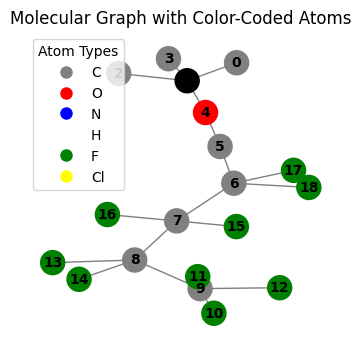

Compound:  C1(C(C(C(C1(F)F)(F)F)(F)F)(F)F)(N2C(C(OC(C2(F)F)(F)F)(F)F)(F)F)F
nodes:  28
edges:  58


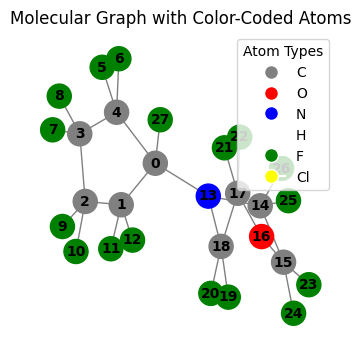

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from rdkit import Chem

def DisplayModel(data, figsize=(4, 4)):  # Add figsize argument
    """
    Displays a molecular graph with color-coded atoms.

    Args:
        data (torch_geometric.data.Data): The graph data to display.
    """
    # Convert PyG Data to NetworkX graph
    G = to_networkx(data, to_undirected=True)

    print("Compound: ", data.smiles)
    print("nodes: ", data.num_nodes)
    print("edges: ", data.num_edges)


    # Get atom types from the SMILES string
    mol = Chem.MolFromSmiles(data.smiles)
    atom_types = [atom.GetSymbol() for atom in mol.GetAtoms()]

    # Define a color dictionary for atom types
    atom_colors = {
        'C': 'gray',
        'O': 'red',
        'N': 'blue',
        'H': 'white',
        'F': 'green',
        'Cl': 'yellow',  # Add more atom types and colors as needed
        # ...
    }

    # Get node colors based on atom types
    node_colors = [atom_colors.get(atom_type, 'black') for atom_type in atom_types]

    # Set figure size and layout
    plt.figure(figsize=figsize)  # Use the figsize argument
    pos = nx.spring_layout(G, seed=42)

    # Draw nodes, edges, and labels
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    # Add a legend for atom colors
    legend_labels = list(atom_colors.keys())
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
                      for color in atom_colors.values()]
    plt.legend(legend_handles, legend_labels, title='Atom Types')

    # Remove axis and add title
    plt.axis('off')
    plt.title("Molecular Graph with Color-Coded Atoms")

    plt.show()

DisplayModel(train_dataset2[0])
DisplayModel(train_dataset2[1])

plt.show()


In [42]:
from re import X
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_mean_pool
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import LayerNorm
import ast

class GCN(torch.nn.Module):

    def __init__(self, num_node_features, hidden_channels, num_classes=10):

        super(GCN, self).__init__()
        self.conv1 = GATConv (num_node_features, hidden_channels)
        self.conv2 = GATConv (hidden_channels, hidden_channels)
        self.conv3 = GATConv (hidden_channels, hidden_channels)
        self.conv4 = GATConv (hidden_channels, hidden_channels)

        self.global_mlp = torch.nn.Sequential(
            torch.nn.Linear(num_global_features, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, hidden_channels)
        )

        self.norm1 = LayerNorm(hidden_channels)  # Changed to LayerNorm
        self.norm2 = LayerNorm(hidden_channels)
        self.norm3 = LayerNorm(hidden_channels)
        self.norm4 = LayerNorm(hidden_channels)

        self.lin1 = torch.nn.Linear(hidden_channels + hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch, global_features):
        # GCN layers with skip connections
        x1 = F.relu(self.conv1(x, edge_index))
        x1 = self.norm1(x1)
        x2 = F.relu(self.conv2(x1, edge_index))
        x2 = self.norm2(x2 + x1)  # Skip connection
        x3 = F.relu(self.conv3(x2, edge_index))
        x3 = self.norm3(x3 + x2)  # Skip connection
        x4 = self.conv4(x3, edge_index)
        x4 = self.norm4(x4 + x3)  # Skip connection

        # Pooling
        graph_embedding = global_mean_pool(x4, batch)

        # Global features
        global_features = global_features.view(-1, num_global_features)
        global_features = self.global_mlp(global_features)

        # Concatenate and classify
        x = torch.cat([graph_embedding, global_features], dim=1)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.lin2(x)
        return x



def train(model, train_loader, optimizer, criterion, device):
    model.train()  # Set model to training mode


    total_loss = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()  # Clear gradients
        # Forward pass
        out = model(  data.x,
                      data.edge_index,
                      data.batch,
                      data.global_features
                      )

        loss = criterion(out, data.y.long()) # Compute loss

        # Backward pass
        loss.backward()  # Compute gradients

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch, data.global_features)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    return (correct / total)*100

In [46]:
from torch_geometric.data import DataLoader
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
import time
from torch_geometric.utils import to_networkx


# Data generated
embeddings = []
losses = []
accuracies = []
outputs = []
targets = []

# Model initialization
num_node_features = train_dataset2.get(1).num_node_features
num_global_features = train_dataset2[0].global_features.shape[0]
num_graph_features = 5
num_edge_features = train_dataset2.get(1).num_edge_features
hidden_channels =512
num_classes = 5
lr=0.001


model = GCN(num_node_features, hidden_channels, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


# Lists to store loss and accuracy
train_losses = []
test_accuracies = []

# Use GPU for training, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Data loader
NUM_GRAPHS_PER_BATCH = 512
NUM_EPOCHS = 200

train_loader2 = DataLoader(train_dataset2, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True, num_workers = 32, pin_memory=True)
test_loader2 = DataLoader(test_dataset2, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True, num_workers = 32, pin_memory=True)

print('\n======== data distribution =======\n')
print("Size of training data: {} graphs".format(len(train_dataset2)))
print("Size of testing data: {} graphs".format(len(test_dataset2)))


print('\n======== Starting training ... =======\n')
start_time = time.time()

losses = []
for epoch in range(NUM_EPOCHS):
    train_loss = train(model=model, train_loader=train_loader2, optimizer=optimizer, criterion=criterion,device=device)



    test_acc = evaluate(model, test_loader2, device)

    if(epoch %10 ==0):
        print(f"Epoch: {epoch}, Training Loss: {train_loss}, Test Accuracy: {test_acc}")

    # Store loss and accuracy
    train_losses.append(train_loss)
    test_accuracies.append(test_acc)

print("\nTraining done!\n")
elapsed = time.time() - start_time
minutes_e = elapsed//60
print("--- training took:  %s minutes ---" % (minutes_e))


======== data distribution =======

Size of training data: 279243 graphs
Size of testing data: 69813 graphs

======== Starting training ... =======

Epoch: 0, Training Loss: 1.5172267869496956, Test Accuracy: 63.23750590864166
Epoch: 10, Training Loss: 0.8304594292308821, Test Accuracy: 65.67401486829101
Epoch: 20, Training Loss: 0.8094795699957963, Test Accuracy: 65.65252889862919
Epoch: 30, Training Loss: 0.8030840933541239, Test Accuracy: 65.85449701345021
Epoch: 40, Training Loss: 0.7801380930366096, Test Accuracy: 65.92754931030036


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e5182f804a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e5182f804a0>    if w.is_alive():

Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      self._shutdown_workers() Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e5182f804a0>     File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^
^    if w.is_alive():Traceback (most recent call last):
^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", l

RuntimeError: DataLoader worker (pid(s) 182371, 182387) exited unexpectedly

^^ 
^ ^^  ^^^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^^^^^^^    
^AssertionError^: ^

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score  # Choose an appropriate metric

def permutation_importance(model, loader, device, feature_index):
    model.eval()
    original_predictions = []
    permuted_predictions = []
    true_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            original_output = model(data.x, data.edge_index, data.batch, data.global_features)
            original_predictions.extend(original_output.argmax(dim=1).cpu().numpy())
            true_labels.extend(data.y.cpu().numpy())

            # Permute the specified feature
            permuted_data = data.clone()
            permuted_data.x[:, feature_index] = torch.rand_like(permuted_data.x[:, feature_index])
            permuted_output = model(permuted_data.x, permuted_data.edge_index, permuted_data.batch, permuted_data.global_features)
            permuted_predictions.extend(permuted_output.argmax(dim=1).cpu().numpy())

    original_accuracy = accuracy_score(true_labels, original_predictions)
    permuted_accuracy = accuracy_score(true_labels, permuted_predictions)
    importance = original_accuracy - permuted_accuracy  # Calculate importance
    return importance

feature_importances = []
for feature_index in range(train_dataset2.num_node_features):  # Assuming node features are of interest
    importance = permutation_importance(model, test_loader2, device, feature_index)
    feature_importances.append(importance)






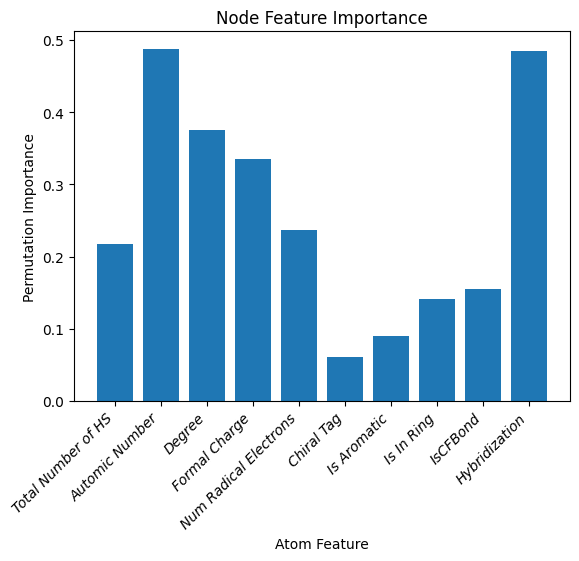

In [14]:

import matplotlib.pyplot as plt
features=["Total Number of HS", "Automic Number", "Degree", "Formal Charge", "Num Radical Electrons", "Chiral Tag", "Is Aromatic", "Is In Ring", "IsCFBond", "Hybridization"]

#plt.bar(range(len(feature_importances)), feature_importances)
plt.bar(features, feature_importances)
plt.xticks(rotation=45, ha="right", style='oblique')
plt.xlabel('Atom Feature')
plt.ylabel('Permutation Importance')
plt.title('Node Feature Importance')
plt.show()


In [ ]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
losses_np = np.array([x.item() for x in losses])
outs = [i[0] for i in outputs]
outputs_np = np.array([x.item() for x in outs])
targs = [i[0] for i in targets]
targets_np = np.array([x.item() for x in targs])

results = pd.concat([pd.DataFrame(losses_np),
                     pd.DataFrame(accuracies),
                     pd.DataFrame(outputs_np),
                     pd.DataFrame(targets_np)], axis= 1)
results.columns = ['losses', 'accuracy', 'pred', 'target']
results.head()

,losses,accuracy,pred,target
0,0.759018,66.324786,3,3.0
1,0.657096,73.048433,0,1.0
2,0.663343,73.675214,1,3.0
3,0.600349,75.156695,2,2.0
4,0.613021,75.384615,0,1.0


In [ ]:
ymin, ymax = np.floor(min(results[[ 'pred', 'target']].min())),\
    round(max(results[[ 'pred', 'target']].max()))

# all training
training_acc = r2_accuracy(results["target"], results["pred"])

#first 20 epochs
training_acc_1st_20 = r2_accuracy(results["target"][:20], results["pred"][:20])

# last 20 epochs
training_acc_last_20 = r2_accuracy(results["target"][-20:], results["pred"][-20:])

print("Training accuracy: {}%".format(round(training_acc, 2)))
print("1st 20 Training accuracy: {}%".format(round(training_acc_1st_20, 2)))
print("Last 20 Training accuracy: {}%".format(round(training_acc_last_20, 2)))

NameError: name 'results' is not defined

FileNotFoundError: [Errno 2] No such file or directory: '/content/assets/images/pred_vs_targ.png'

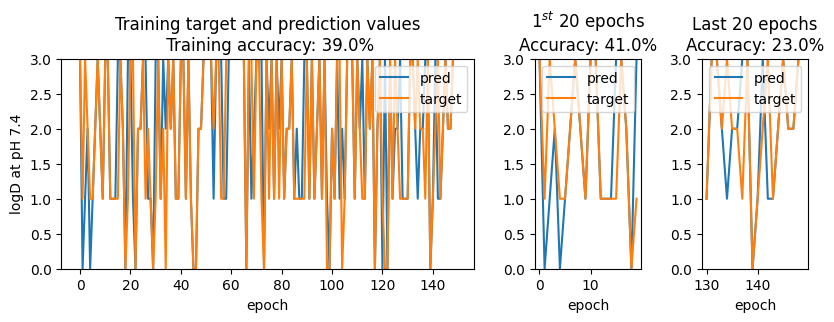

In [ ]:
import matplotlib.pyplot as plt

# creating grid for subplots
fig = plt.figure(figsize=(10,6))

ax1 = plt.subplot2grid(shape=(2, 28), loc=(0,0), colspan=15)
ax2 = plt.subplot2grid(shape=(2, 28), loc=(0,17), colspan=4)
ax3 = plt.subplot2grid(shape=(2, 28), loc=(0,23), colspan=4)


results[[ 'pred', 'target']].plot(title='Training target and prediction values\n Training accuracy: ' + str(round(training_acc, 2) )+ '%',
                                  xlabel='epoch', ylabel = 'logD at pH 7.4', ax=ax1, ylim = (ymin, ymax) )
results[[ 'pred', 'target']][:20].plot(title="$1^{st}$ 20 epochs\nAccuracy: " + str(round(training_acc_1st_20, 2)) +'%',
                                       xlabel='epoch', ax=ax2, ylim = (ymin, ymax))
results[[ 'pred', 'target']][-20:].plot(title="Last 20 epochs\nAccuracy: " + str(round(training_acc_last_20, 2)) +'%',
                                       xlabel='epoch', ax=ax3, ylim = (ymin, ymax))
fig.savefig('assets/images/pred_vs_targ.png', bbox_inches='tight')

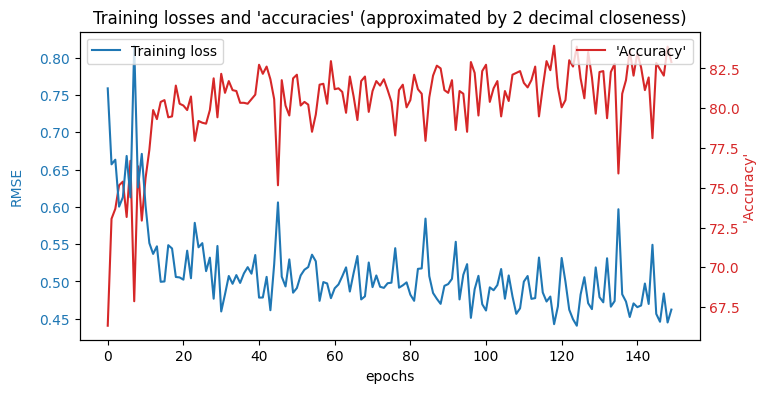

FileNotFoundError: [Errno 2] No such file or directory: '/content/assets/images/losses_and_accuracies.png'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(8,4))

color1 = 'tab:red'
ax1.set_xlabel('epochs')

ax1.tick_params(axis='y', labelcolor=color1)
sns.lineplot(data=results.accuracy, label="'Accuracy'", color=color1, ax=ax1)
plt.legend(loc='upper right')

ax2 = ax1.twinx()

color2 = 'tab:blue'
ax1.set_ylabel('RMSE' , color=color2, labelpad=40)
ax2.set_ylabel("'Accuracy'", color=color1, labelpad=30)

ax2.tick_params(axis='y', labelcolor=color2)
sns.lineplot(data=losses_float, label='Training loss', color=color2, ax=ax2)
plt.legend(loc='upper left')

ax1.yaxis.tick_right()
ax2.yaxis.tick_left()

plt.title("Training losses and 'accuracies' (approximated by 2 decimal closeness)")

plt.show()
fig.tight_layout()
fig.savefig('assets/images/losses_and_accuracies.png', bbox_inches='tight')

In [ ]:
import pandas as pd

result = pd.DataFrame()

# One batch prediction
test_batch = next(iter(test_loader2))
with torch.no_grad():
    test_batch.to(device)
    pred = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch,test_batch.species, test_batch.sex, test_batch.dosing_adj)
    result["y"] = test_batch.y.tolist()
    result["y_pred"] = pred.tolist()

df["real"] = df["y"].apply(lambda row: row[0])
df["pred"] = df["y_pred"].apply(lambda row: row[0])
df.head()


TypeError: 'float' object is not subscriptable